# Проект: Сервис поиска похожих вопросов для медицинских форумов

## Описание

### Цель

Целью данного проекта является разработка сервиса для поиска похожих вопросов на медицинских форумах. Сервис поможет удержать пользователей на платформе и увеличить количество просмотров страниц, что в свою очередь повысит эффективность рекламных кампаний и улучшит общие показатели форумов.

### Исходные данные

Для обучения и тестирования моделей используется датасет "medical_questions_pairs" от Hugging Face.  Датасет содержит пары вопросов на английском языке, связанных с медицинской тематикой.

### Методы

В проекте будут использованы следующие методы и технологии:

* Обработка естественного языка (NLP) для анализа и предобработки текстовых данных.
* Машинное обучение с использованием различных моделей NLP, таких как Bag-of-Words, TF-IDF, Word2Vec, SentenceTransformers и BERT. 
* FastAPI для создания микросервиса, предоставляющего функциональность поиска похожих вопросов.
* Streamlit для разработки интерактивного веб-приложения для демонстрации работы сервиса.

### Метрики оценки

Качество матчинга вопросов будет оцениваться с использованием следующих метрик: 

* Accuracy@5 - `ключевая метрика`
* MRR@K (Mean Reciprocal Rank)
* DCG@K (Discounted Cumulative Gain)
* AccuracyTriplet - доля правильно классифицированных триплетов

## Импорты

In [2]:
import time
from collections import defaultdict
from pickle import dump

import chime
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
from datasets import load_dataset
from gensim.models import Word2Vec
from scipy.spatial.distance import pdist, squareform
from sentence_transformers import (InputExample, LoggingHandler,
                                   SentenceTransformer, losses, util)
from skimpy import skim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import dcg_score
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader
from tqdm import tqdm

# Настройка библиотек
%load_ext chime
chime.theme('mario')
plt.style.use('dark_background')

## Загрузка и обзор данных

In [ ]:
DIR = 'data/'

In [2]:
# Загрузка датасета medical_questions_pairs
try:
    train_df = pd.read_csv(DIR+'train.csv')

except:
    
    dataset = load_dataset("medical_questions_pairs")

    train_df = pd.DataFrame(dataset['train'])
    train_df.to_csv(DIR+'train.csv',index=False)

# Изучение структуры датасета
print('TRAIN')
print(train_df.info())
print('-------------------')
print()
print('TRAIN')
skim(train_df)
display(train_df.head(3))
print(f'Количество дубликатов: {train_df.duplicated().sum()}')
print(f'Количество уникальных question_1: {train_df.question_1.unique().shape[0]}')
print(f'Количество уникальных question_2: {train_df.question_2.unique().shape[0]}')
all_unique_questions = set(list(train_df.question_1.unique())+list(train_df.question_2.unique()))
sum_len = len(all_unique_questions)
print(f'Суммарное количество уникальных вопросов: {sum_len}')

TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dr_id       3048 non-null   int64 
 1   question_1  3048 non-null   object
 2   question_2  3048 non-null   object
 3   label       3048 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 95.4+ KB
None
-------------------

TRAIN


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3048   │ │ int32       │ 2     │                                                          │
│ │ Number of columns │ 4      │ │ string      │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA    ┃ NA %     ┃ mean     ┃ sd     ┃ p0    ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ dr_id               │     0 │        0 │        6 │    3.1 │     1 │      3 │      9 │      11 │  ██▄███   │  │
│ │ label               │     0 │        0 │      0.5 │    0.5 │     0 │      0 │      1 │       1 │  █    █   │  │
│ └─────────────────────┴───────┴──────────┴──────────┴────────┴───────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ question_1                │       0 │          0 │                           19 │                    57264 │  │
│ │ question_2                │       0 │          0 │                           19 │                    57264 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,dr_id,question_1,question_2,label
0,1,After how many hour from drinking an antibioti...,I have a party tonight and I took my last dose...,1
1,1,After how many hour from drinking an antibioti...,I vomited this morning and I am not sure if it...,0
2,1,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 19...,1


Количество дубликатов: 0
Количество уникальных question_1: 1524
Количество уникальных question_2: 3043
Суммарное количество уникальных вопросов: 4567


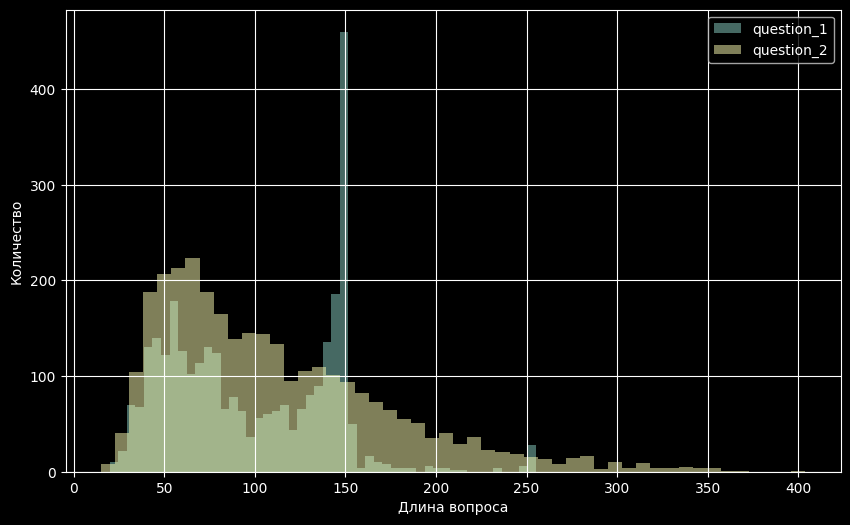

In [3]:
# Анализ длины вопросов
train_df['question_1_length'] = train_df['question_1'].str.len()
train_df['question_2_length'] = train_df['question_2'].str.len()

# Визуализация распределения длины вопросов
plt.figure(figsize=(10, 6))
train_df['question_1_length'].hist(bins=50, alpha=0.5, label='question_1')
train_df['question_2_length'].hist(bins=50, alpha=0.5, label='question_2')
plt.set_cmap('Greens')
plt.xlabel('Длина вопроса')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [4]:
train_df['question_1_length'].describe()

count    3048.000000
mean       99.858924
std        45.640730
min        20.000000
25%        58.000000
50%        94.000000
75%       144.000000
max       255.000000
Name: question_1_length, dtype: float64

In [5]:
train_df['question_2_length'].describe()

count    3048.000000
mean      110.334646
std        63.029785
min        15.000000
25%        62.000000
50%        95.000000
75%       146.000000
max       404.000000
Name: question_2_length, dtype: float64

## Предобработка

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

# Загрузка модели spaCy
nlp = spacy.load("en_core_web_trf")

def preprocess_text(text):
    """
    Функция для предобработки текста.

    Args:
        text (str): Входной текст.

    Returns:
        list: Список обработанных токенов.
    """
    # Токенизация
    tokens = nltk.word_tokenize(text.lower())  # Приведение к нижнему регистру

    # Удаление пунктуации
    tokens = [token for token in tokens if token.isalnum()]

    # Удаление стоп-слов
    stop_words = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]

    # Лемматизация
    tokens = [token.lemma_ for token in nlp(" ".join(tokens))]

    # Обработка неизвестных слов (замена на UNK)
    tokens = [token if token != '-PRON-' else 'UNK' for token in tokens]

    return " ".join(tokens)

[nltk_data] Downloading package punkt to C:\Users\elpiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elpiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess_dataframe(df):
    """
    Функция для предобработки DataFrame с вопросами.

    Args:
        df (pd.DataFrame): DataFrame с вопросами.

    Returns:
        pd.DataFrame: DataFrame с предобработанными вопросами.
    """
    df['processed_question_1'] = df['question_1'].apply(preprocess_text)
    df['processed_question_2'] = df['question_2'].apply(preprocess_text)
    return df

In [8]:
try:
    train_df = pd.read_csv(DIR+'prep_train.csv')
except:
    train_df = preprocess_dataframe(train_df).fillna('No')
    train_df.to_csv(DIR+'prep_train.csv', index=False)

## Тестирование моделей

### Функции

In [9]:
def create_index(df, model=None, text_cols = ['processed_question_1','processed_question_2'], dump_pkl=False):
    """
    Создает индекс-эмбеддингов и словари для поиска похожих вопросов.

    Args:
        df (pd.DataFrame): DataFrame с текстовыми вопросами.
        model (str): Модель SentenceTransformer для создание эмбеддингов. Если None, то словарь индекс-имбеддингов не создаётся.
                    По умолчанию - None
        text_cols (list): Названия текстовых столбцов - 2 текстовых элемента в списке.
                        По умолчанию - ['processed_question_1','processed_question_2'].
        dump (bool): Если True, то сохраняет словари в файлы 'pkl'. По умолчанию - False.
        
    Returns:
        tuple: (словарь индекс-эмбеддингов, словарь индекс-вопрос, словарь вопрос-индекс, словарь с ground truth)
        (Или без словаря индекс-эмбеддингов, если model = None)
    """
    corpus = list(set(df[text_cols[0]].tolist() + df[text_cols[1]].tolist()))
    sen2idx = {text: i for i, text in enumerate(corpus)}
    idx2sen = {v: k for k, v in sen2idx.items()}
    if model:
        idx2emd = {i: model.encode(str(text)) for i, text in idx2sen.items()}

    if dump_pkl:
        with open(DIR+"idx2emb.pkl", "wb") as fid:
            dump(idx2emd, fid)
        with open(DIR+"idx2sen.pkl", "wb") as fid:
            dump(idx2sen, fid)
        with open(DIR+"sen2idx.pkl", "wb") as fid:
            dump(sen2idx, fid)

    gt = defaultdict(list)
    for _, row in df.iterrows():
        idx1 = sen2idx[row[text_cols[0]]]
        idx2 = sen2idx[row[text_cols[1]]]

        if row.label:
            gt[idx1].append(idx2)
            gt[idx2].append(idx1)

    if model:    
        return idx2emd, idx2sen, sen2idx, gt
    else:
        return idx2sen, sen2idx, gt


In [10]:
def evaluate_model(idx2emd, gt, n=5, model_type = 'SentenceTransformer', return_top_n_idx = False):
    """
    Оценивает модель SentenceTransformer на предоставленных данных.

    Args:
        idx2emd (dict): Словарь с индекс-эмбеддингами.
        gt (dict): Словарь с ground truth.
        n (int): Число, обозначающее N. По умолчанию - 5.

    Returns:
        tuple: (accuracy@n, mrr@k, dcg@k)
    """
    if model_type == 'SentenceTransformer':
        emb_list = []
        for i in range(len(idx2emd)):
            emb_list.append(idx2emd[i])
        arr = np.array(emb_list)
        dist = pdist(arr, metric="cosine")
        dist_matrix = squareform(dist)
        top_n_idx = np.argsort(dist_matrix)[:, :n+1]

    else:
        dist_matrix = cosine_similarity(idx2emd)
        mask = np.eye(dist_matrix.shape[0], dtype=bool)
        dist_matrix[mask] = 0  
        top_n_idx = np.argsort(dist_matrix)[:, -n:][:, ::-1]

    acc = []
    mrr_at_k = []
    dcg_at_k = []
    for j in range(top_n_idx.shape[0]):
        
        if model_type == 'SentenceTransformer':
            # Исключаем первый схожий вопрос
            rec_idx = top_n_idx[j, 1:]
        else:
            rec_idx = top_n_idx[j, :]

        gt_idx = gt.get(j, [])
        if len(gt_idx) > 0:
            
            # Accuracy@N
            intersection = set(rec_idx).intersection(set(gt_idx))
            acc.append(len(intersection) > 0)

            # MRR@K
            ranking = [idx in gt_idx for idx in rec_idx]
            if any(ranking):
                mrr_at_k.append(1 / (ranking.index(True) + 1))
            else:
                mrr_at_k.append(0)

            # DCG@K 
            relevance = [1 if idx in gt_idx else 0 for idx in rec_idx]
            ideal_ranking = sorted(relevance, reverse=True)
            dcg_at_k.append(dcg_score([relevance], [ideal_ranking], k=n))

    if return_top_n_idx:
        return np.mean(acc), np.mean(mrr_at_k), np.mean(dcg_at_k), top_n_idx
    else:
        return np.mean(acc), np.mean(mrr_at_k), np.mean(dcg_at_k)


def evaluate_SentenceTransformer(model_name, df, text_cols=['processed_question_1', 'processed_question_2']):
    """
    Оценивает модель SentenceTransformer на предоставленных данных.

    Args:
        model_name (str): Название модели SentenceTransformer.
        df (pd.DataFrame): DataFrame с текстовыми вопросами.
        text_cols (list): Названия текстовых столбцов - 2 текстовых элемента в списке.
                        По умолчанию - ['processed_question_1', 'processed_question_2'].

    Returns:
        tuple: (accuracy@5, mrr@5, dcg@5)
    """

    model = SentenceTransformer(model_name)
    idx2emd, _, _, gt = create_index(df, model, text_cols)
    accuracy, mrr, dcg = evaluate_model(idx2emd, gt)
    return accuracy, mrr, dcg

### Bag-of-Words (BoW)

In [18]:
# Получание ground truth
_, _, gt = create_index(train_df, text_cols = ['question_1','question_2'])

# Объединение question_1 и question_2 в один DataFrame
all_questions_df = pd.DataFrame({'question': list(all_unique_questions)})

# Создание объекта CountVectorizer
vectorizer = CountVectorizer()

# Векторизация всех вопросов
all_question_vectors = vectorizer.fit_transform(all_questions_df['question'])

# Оценка качества модели
accuracy, mrr, dcg = evaluate_model(all_question_vectors, gt, model_type = 'BoW')

print('Без предобработки текста.')
print("Accuracy@5 (Bag-of-Words):", accuracy)
print("MRR@5 (Bag-of-Words):", mrr)
print("DCG@5 (Bag-of-Words):", dcg)

Без предобработки текста.
Accuracy@5 (Bag-of-Words): 0.5695538057742782
MRR@5 (Bag-of-Words): 0.47404855643044624
DCG@5 (Bag-of-Words): 0.48861621031668206


In [19]:
# Получание ground truth из предобработанных вопросов
_, _, prep_gt = create_index(train_df)

# Объединение предобработанных question_1 и question_2 в один DataFrame
all_unique_prep_questions = set(
    list(train_df['processed_question_1'].unique()) +
    list(train_df['processed_question_2'].unique())
)
all_prep_questions_df = pd.DataFrame({'question': list(all_unique_prep_questions)})

# Создание объекта CountVectorizer
vectorizer = CountVectorizer()

# Векторизация всех вопросов
all_question_vectors = vectorizer.fit_transform(all_prep_questions_df['question'])

# Оценка качества модели
accuracy, mrr, dcg = evaluate_model(all_question_vectors, prep_gt, model_type = 'BoW')
print('С предобработкой текста.')
print("Accuracy@5 (Bag-of-Words):", accuracy)
print("MRR@5 (Bag-of-Words):", mrr)
print("DCG@5 (Bag-of-Words):", dcg)

С предобработкой текста.
Accuracy@5 (Bag-of-Words): 0.8022988505747126
MRR@5 (Bag-of-Words): 0.679896004378763
DCG@5 (Bag-of-Words): 0.6960162318565597


***Выводы по результатам Bag-of-Words:***

* **Предобработка текста значительно улучшает качество модели Bag-of-Words.** Accuracy@5 увеличилась с 0.57 до 0.80, MRR@5 - с 0.47 до 0.68, а DCG@5 - с 0.49 до 0.70. Это говорит о том, что предобработка текста, такая как токенизация, лемматизация и удаление стоп-слов, помогает модели лучше понимать семантическое сходство между вопросами.

* **Модель Bag-of-Words может быть хорошим выбором, если важна простота и скорость работы.** Она требует меньше ресурсов для обучения и использования, чем более сложные модели такие как SentenceTransformers.

*Код для создания словаря индекс-эмбеддингов (если нужно):*

```python
idx2emd = {i: all_prep_questions_df[i].toarray()[0] for i in range(all_prep_questions_df.shape[0])}
```

### TF-IDF

In [58]:
# Создание объекта CountVectorizer
vectorizer = TfidfVectorizer()

# Векторизация всех вопросов
all_question_vectors = vectorizer.fit_transform(all_prep_questions_df['question'])

# Оценка качества модели
accuracy, mrr, dcg = evaluate_model(all_question_vectors, prep_gt, model_type='TF-IDF')
print('С предобработкой текста.')
print("Accuracy@5 (TF-IDF):", accuracy)
print("MRR@5 (TF-IDF):", mrr)
print("DCG@5 (TF-IDF):", dcg)

С предобработкой текста.
Accuracy@5 (TF-IDF): 0.8623973727422003
MRR@5 (TF-IDF): 0.732632731253421
DCG@5 (TF-IDF): 0.7455033356734234


***Выводы по результатам TF-IDF:***

* **TF-IDF превосходит Bag-of-Words по всем метрикам.** Accuracy@5 увеличилась с 0.80 до 0.86, MRR@5 - с 0.68 до 0.73, а DCG@5 - с 0.70 до 0.75. Это говорит о том, что веса TF-IDF, которые учитывают важность слов в коллекции документов, позволяют модели лучше различать похожие и непохожие вопросы.
* **TF-IDF может быть хорошим компромиссом между качеством и сложностью.** Она обеспечивает значительно лучшее качество, чем Bag-of-Words, при этом оставаясь относительно простой и быстрой в использовании.

*Код для создания словаря индекс-эмбеддингов (если нужно):*

```python
idx2emd = {i: all_prep_questions_df[i].toarray()[0] for i in range(all_prep_questions_df.shape[0])}
```

### Word2Vec

In [18]:
def vectorize_sentence(sentence, model_w2v):
    """
    Векторизует предложение с помощью Word2Vec, усредняя векторы слов.

    Args:
        sentence (str): Предложение для векторизации.
        model_w2v (gensim.models.Word2Vec): Модель Word2Vec.

    Returns:
        numpy.ndarray: Векторное представление предложения.
    """
    words = sentence.split()
    word_vectors = [model_w2v.wv[word] for word in words if word in model_w2v.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model_w2v.vector_size)

In [69]:
# Объединение всех вопросов в один список
all_questions = train_df['processed_question_1'].tolist() + train_df['processed_question_2'].tolist()

# Разделение вопросов на списки токенов
all_tokens = [question.split() for question in all_questions]

# Обучение Word2Vec
model_w2v = Word2Vec(sentences=all_tokens, vector_size=512, window=5, min_count=5, workers=4)

# Векторизация всех вопросов
all_question_embeddings = []
for question in all_prep_questions_df['question']:
    all_question_embeddings.append(vectorize_sentence(question, model_w2v))

# Создание словаря idx2emd
idx2emd = {i: embedding for i, embedding in enumerate(all_question_embeddings)}

# Оценка качества модели
accuracy, mrr, dcg = evaluate_model(all_question_embeddings, prep_gt, model_type='Word2Vec')
print('С предобработкой текста.')
print("Accuracy@5 (Word2Vec):", accuracy)
print("MRR@5 (Word2Vec):", mrr)
print("DCG@5 (Word2Vec):", dcg) 

С предобработкой текста.
Accuracy@5 (Word2Vec): 0.4380952380952381
MRR@5 (Word2Vec): 0.36174603174603165
DCG@5 (Word2Vec): 0.3737529871438364


***Выводы по результатам Word2Vec:***

* **Word2Vec показал значительно худшие результаты, чем Bag-of-Words и TF-IDF по всем метрикам.** 
   Это говорит о том, что усреднение векторов слов, полученных из Word2Vec, 
   не является эффективным способом представления семантического сходства между вопросами в нашей задаче.
* **Возможные причины:** 
   * **Потеря информации при усреднении:** Усреднение векторов слов может привести к потере информации о порядке слов и синтаксической структуре предложения. 
   * **Размер датасета:** Наш датасет может быть недостаточно большим для обучения качественной модели Word2Vec. 
   * **Выбор параметров Word2Vec:** Возможно, выбранные параметры (размерность векторов, размер окна контекста, минимальная частота слов) не оптимальны для нашей задачи. (Были опробованы и другие параметры, но их изменение не привело к сильному улучшению метрики. В данном коде оставлен лучший вариант.)

* **В целом, результаты показывают, что модель Word2Vec не подходит для нашей задачи поиска похожих вопросов.**  
   Мы можем попробовать использовать другие модели, которые лучше учитывают семантику и структуру предложений.

### USE

In [1]:
import tensorflow_hub as hub

# URL модели USE
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 

# Загрузка модели
model_use = hub.load(module_url)

In [24]:
# Векторизация всех вопросов
all_question_embeddings = model_use(all_prep_questions_df['question']).numpy()

# Создание словаря idx2emd
idx2emd = {i: embedding for i, embedding in enumerate(all_question_embeddings)}

# Оценка качества модели
accuracy, mrr, dcg = evaluate_model(all_question_embeddings, prep_gt, model_type='USE')
print('С предобработкой текста.')
print("Accuracy@5 (USE):", accuracy)
print("MRR@5 (USE):", mrr)
print("DCG@5 (USE):", dcg) 

С предобработкой текста.
Accuracy@5 (USE): 0.870935960591133
MRR@5 (USE): 0.7614668856048166
DCG@5 (USE): 0.7734119728925425


In [22]:
# Векторизация всех вопросов
all_question_embeddings = model_use(all_questions_df['question']).numpy()

# Создание словаря idx2emd
idx2emd = {i: embedding for i, embedding in enumerate(all_question_embeddings)}

# Оценка качества модели
accuracy, mrr, dcg = evaluate_model(all_question_embeddings, gt, model_type='USE')
print('Без предобработки текста.')
print("Accuracy@5 (USE):", accuracy)
print("MRR@5 (USE):", mrr)
print("DCG@5 (USE):", dcg) 

Без предобработки текста.
Accuracy@5 (USE): 0.8887795275590551
MRR@5 (USE): 0.7894192913385826
DCG@5 (USE): 0.8017842326493311


***Выводы по результатам USE:***

* **USE  показал отличные результаты,  как на исходных,  так и на предобработанных данных.** 
   Accuracy@5  для обоих вариантов выше,  чем у Bag-of-Words и TF-IDF.
* **Предобработка текста не привела к значительному улучшению или ухудшению качества.**  
   Это может говорить о том,  что USE  уже достаточно хорошо справляется с обработкой текста и не так чувствительна к предобработке,  как более простые модели.
* **USE  может быть хорошим выбором,  если нужно высокое качество и простота использования.**  
   Модель уже предобучена и готова к использованию,  не требуя дополнительного обучения. 

* **В целом,  результаты показывают,  что USE  - это эффективная модель для поиска похожих вопросов,  которая обеспечивает высокое качество и простоту использования.**

### SentenceTransformers

In [9]:
def colorize_metrics_df(df):
    return (df.sort_values('DCG@5', ascending=0)
            .reset_index(drop=True)
            .style
            .set_caption("Метрики моделей SentenceTransformer")
            .format("{:.2%}",subset=metrics_cols)
            .format(precision=2,subset=['time'])
            .background_gradient(cmap='summer',subset=metrics_cols)
            .background_gradient(cmap='summer_r',subset=['time']))

In [16]:
%%time
%%chime

model_names = [ 'all-MiniLM-L6-v2',
                'paraphrase-MiniLM-L3-v2',
                'all-MiniLM-L12-v2',
                'multi-qa-MiniLM-L6-cos-v1',
                'paraphrase-multilingual-mpnet-base-v2',
                'all-distilroberta-v1',
                'multi-qa-distilbert-cos-v1',
                'multi-qa-mpnet-base-dot-v1',
                'all-mpnet-base-v2'
                ]

metrics_cols = ['Accuracy@5','MMR@5','DCG@5']

try:
    metrics = metrics.dropna()
    counter = metrics.shape[0]+1
except:
    try:
        metrics = pd.read_csv(DIR+'metrics.csv').dropna()
        counter = metrics.shape[0]+1
    except:
        metrics = pd.DataFrame(columns=['model','text_type'])
        counter = 0
    

for text_type in ['Изначальный', 'Предобработаный']:
    for model_name in model_names:

        if (metrics.shape[0] == 0 or
            model_name+text_type not in (metrics.model + metrics.text_type).to_list()):

            metrics.loc[counter,'model'] = model_name
            metrics.loc[counter,'text_type'] = text_type
            
            if text_type == 'Изначальный':
                text_cols=['question_1', 'question_2']
            else:
                text_cols=['processed_question_1','processed_question_2']

            start = time.time()
            accuracy, mrr, dcg = evaluate_SentenceTransformer(model_name, train_df, text_cols)
            end = time.time()

            metrics.loc[counter,'Accuracy@5'] = round(accuracy, 4)
            metrics.loc[counter,'MMR@5'] = round(mrr, 4)
            metrics.loc[counter,'DCG@5'] = round(dcg, 4)
            metrics.loc[counter,'time'] = round(end-start, 4)

            counter +=1
            
            metrics_colored = colorize_metrics_df(metrics)

            display(metrics_colored, clear = True)

        else:
            metrics_colored = colorize_metrics_df(metrics)
            pass

display(metrics_colored, clear = True)

,model,text_type,Accuracy@5,MMR@5,DCG@5,time
0,all-mpnet-base-v2,Изначальный,96.82%,90.94%,91.67%,655.86
1,all-MiniLM-L6-v2,Изначальный,96.36%,90.39%,90.94%,119.97
2,all-MiniLM-L12-v2,Изначальный,95.87%,90.13%,90.75%,221.17
3,multi-qa-distilbert-cos-v1,Изначальный,95.60%,89.95%,90.57%,298.25
4,multi-qa-MiniLM-L6-cos-v1,Изначальный,95.83%,88.83%,89.49%,119.93
5,multi-qa-mpnet-base-dot-v1,Изначальный,95.24%,88.55%,89.37%,647.01
6,all-distilroberta-v1,Изначальный,94.78%,87.23%,88.05%,301.65
7,paraphrase-multilingual-mpnet-base-v2,Изначальный,91.96%,84.95%,85.82%,601.49
8,multi-qa-distilbert-cos-v1,Предобработаный,92.91%,83.69%,84.59%,239.22
9,all-MiniLM-L6-v2,Предобработаный,93.27%,83.41%,84.27%,133.37


CPU times: total: 62.5 ms
Wall time: 88 ms


In [14]:
metrics.to_csv(DIR+'metrics.csv', index = False)

**Наблюдения:**
* **Все модели SentenceTransformer показали более высокое качество по всем метрикам чем дергие модели, рассмотренные в этом проекте.** При этом скорость работы этих моделей значительно ниже, но так как для данной задачи скорость работы всё ранво остаётся в пределах нормы, то выбор лучшей модели будет осуществляться среди моделей SentenceTransformer.
* ***Модель all-mpnet-base-v2 показала наилучшую точность (Accuracy@5) как на исходных, так и на предобработанных данных. Точность на исходных данных - 96.82%*** Это говорит о том, что эта модель хорошо подходит для нашей задачи поиска похожих вопросов.
* ***Предобработка текста не привела к улучшению точности.*** В большинстве случаях, точность даже немного снизилась. Это может быть связано с тем, что предобработка удаляет некоторую информацию, которая может быть полезна для модели.
* ***Модели среднего размера (all-MiniLM-L6-v2, all-MiniLM-L12-v2) также показали хорошую точность. Они могут быть хорошим выбором, если важна скорость работы.***
* *Модели, специально обученные для задач Question Answering (multi-qa-MiniLM-L6-cos-v1, multi-qa-distilbert-cos-v1, multi-qa-mpnet-base-dot-v1), показали немного худшую точность, чем all-mpnet-base-v2, all-MiniLM-L6-v2 и all-MiniLM-L12-v2.*
* Метрики `MMR@5`и`DCG@5` на уровене 90%+ (0.9+) указывают на то что в большинстве случаев модель ранжирует правильный вопрос на первое место и реже на второе и ниже.

**Выбор модели:**
- Для дальнейшей разработки я буду использовать модель **`all-MiniLM-L6-v2`**, которая показала почти такой же результат (точность 96.36%) что и `all-mpnet-base-v2`, но при этом работает почти в 6 раз быстрее.

## Fine-tuning модели SentenceTransformers

In [12]:
best = 'all-MiniLM-L6-v2'

In [18]:
def print_metrics(idx2emd, gt, n = 5):
    """
    Печатет метрики модели.

    Args:
        idx2emd (dict): Словарь с индекс-эмбеддингами.
        gt (dict): Словарь с ground truth.
        n (int): Число, обозначающее N. По умолчанию - 5.

    Returns:
        Ничего не вовзращает, только печетает.
        Для получения метрик нужно использовать функцию evaluate_model().
    """
    

    # Вызов функции и evaluate_model
    accuracy, mrr, dcg = evaluate_model(idx2emd, gt, n)

    # Печать результатов
    print(f"Accuracy@{n}: {accuracy:.4f}")
    print(f"MRR@{n}: {mrr:.4f}")
    print(f"DCG@{n}: {dcg:.4f}")

In [31]:
# Создание списка InputExample
train_data = []
for index, row in train_df.iterrows():
    train_data.append(InputExample(texts=[row['question_1'], row['question_2']], label=float(row['label'])))

# Создание DataLoader
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)

In [32]:
%%time
%%chime

# Создание объекта SentenceTransformer
tuned_CosSim_model = SentenceTransformer(best)

# Определение loss-функции
train_loss = losses.CosineSimilarityLoss(tuned_CosSim_model)

# Fine-tuning модели
tuned_CosSim_model.fit(train_objectives=[(train_dataloader, train_loss)],
                                        epochs=3)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

CPU times: total: 56min
Wall time: 19min 49s


In [33]:
idx2emd, _, _, gt = create_index(train_df, tuned_CosSim_model, text_cols = ['question_1','question_2'])

print_metrics(idx2emd, gt, 5)

Accuracy@5: 0.9242
MRR@5: 0.8572
DCG@5: 0.8657


* **Метрики ухудшились, попробую использовать другую loss-функцию - `TripletLoss`**

In [26]:
def create_triplets(df, triplet_type = 'InputExample'):
    """
    Создает триплеты данных для TripletLoss.

    Args:
        df (pd.DataFrame): DataFrame с вопросами и метками.

    Returns:
        list: Список объектов InputExample.
    """
    triplets = []

    for anchor in train_df.question_1.unique():
        for positive in train_df.query('label == 1').loc[train_df['question_1']==anchor,'question_2'].to_list():
            for negative in train_df.query('label == 0').loc[train_df['question_1']==anchor,'question_2'].to_list():
            
                if triplet_type == 'InputExample':
                    triplets.append(InputExample(texts=[anchor, positive, negative]))
                    
                elif triplet_type =='tuple':
                    triplets.append((anchor, positive, negative))
                
    return triplets

In [27]:
def evaluate_triplets(triplets, model):
    """
    Оценивает модель SentenceTransformer на триплетах данных.

    Args:
        triplets (list): Список триплетов (anchor, positive, negative).
        model (SentenceTransformer): Объект SentenceTransformer.

    Returns:
        float: Доля правильно классифицированных триплетов.
    """
    correct = 0
    for anchor, positive, negative in triplets:
        
        # Векторизация предложений
        anchor_embedding = model.encode(anchor)
        positive_embedding = model.encode(positive)
        negative_embedding = model.encode(negative)

        # Вычисление расстояний
        positive_distance = cosine_similarity(anchor_embedding.reshape(1, -1), positive_embedding.reshape(1, -1))[0][0]
        negative_distance = cosine_similarity(anchor_embedding.reshape(1, -1), negative_embedding.reshape(1, -1))[0][0]

        # Проверка условия
        if positive_distance > negative_distance:
            correct += 1

    return correct / len(triplets)

In [34]:
%%time
%%chime

# Создание триплетов данных
train_triplets = create_triplets(train_df)

# Создание DataLoader
train_dataloader = DataLoader(train_triplets, shuffle=True, batch_size=16)

# Создание объекта SentenceTransformer
tuned_TripletLoss_model = SentenceTransformer(best)

# Определение loss-функции
train_loss = losses.TripletLoss(model=tuned_TripletLoss_model)

# Fine-tuning модели
tuned_TripletLoss_model.fit(train_objectives=[(train_dataloader, train_loss)], 
                            epochs=3, 
                            warmup_steps=100
                            )

# Оценка качества модели
idx2emd, _, _, gt = create_index(train_df, tuned_TripletLoss_model,
                                text_cols = ['question_1','question_2'])

print_metrics(idx2emd, gt, 5)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Accuracy@5: 0.3320
MRR@5: 0.2687
DCG@5: 0.2805
CPU times: total: 46min 27s
Wall time: 16min 29s


In [40]:
tuple_train_triplets = create_triplets(train_df, triplet_type='tuple')

base_model = SentenceTransformer(best)

models = [base_model, tuned_CosSim_model, tuned_TripletLoss_model]
names = ['Базовая модель', 'tuned_CosSim_model', 'tuned_TripletLoss_model']

for model, name in zip(models,names):
    AccuracyTriplet =  evaluate_triplets(tuple_train_triplets, model)

    print(f'{name} AccuracyTriplet: {AccuracyTriplet:.2%}')

Базовая модель AccuracyTriplet: 94.82%
tuned_CosSim_model AccuracyTriplet: 96.39%
tuned_TripletLoss_model AccuracyTriplet: 89.83%


* **Базовая модель без дообучения показывает более высокую метрику `AccuracyTriplet` и значительно лучшие показатели целевых метрик `Accuracy@5, MRR@5, DCG@5`, чем модель дообученная с помощью `TripletLoss`***
* **Базовая модель уступает по метрике `AccuracyTriplet` модели дообученой с помощью `CosineSimilarityLoss`, но показывает лучшие показатели целевых метрик `Accuracy@5, MRR@5, DCG@5`**, это означает что дообученная модель правильнее расставляет приоритеты этих вопросов относительно друг-друга, но правильный вопрос реже попадает в топ-5 и оказывается на первых местах.

* В будущем можно попробовать использовать MarginRankingLoss и MultipleNegativesRankingLoss которые подходят для оптимизации MRR@5 и DCG@5, так как они направлены на улучшение ранжирования примеров.

* ***Для построения приложения и микро-сервиса принято решение использовать базовую предобученую модель SentenceTransformer `all-MiniLM-L6-v2`.***

*AccuracyTriplet - доля правильно классифицированных триплетов. Правильно классифицированный триплет - триплет в котором косиносовое сходство между между заданным вопросом и истинным схожим больше чем с неправильным.

.

Рассмотрим примеры выдачи топ-5 схожих вопросов и заодно сохраним получившиеся эмбеддинги.

In [114]:
N = 5

idx2emd, idx2sen, sen2idx, gt = create_index(train_df, base_model,
                                             text_cols=['question_1', 'question_2'],
                                             dump_pkl=True)

# Получение предсказаний (матрица top_n_idx)
_, _, _, top_n_idx = evaluate_model(idx2emd, gt, return_top_n_idx=True)  # Нам нужна только матрица top_n_idx

# Анализ предложенных вопросов
for i in range(len(top_n_idx[:N+1])):
    predicted_indices = top_n_idx[i,1:]
    true_indices = gt.get(i, [])
    if set(predicted_indices).intersection(set(true_indices)):
        print("Вопрос:")
        display(idx2sen[i])
        print("Предсказанные похожие вопросы:")
        display([idx2sen[j] for j in predicted_indices])
        print("Истинный похожий вопрос:")
        display([idx2sen[j] for j in true_indices])
        print("------------------------------------------") 

Вопрос:


"Is there a way for my husband to find out if I'm a virgin or not?"

Предсказанные похожие вопросы:


['Is it possible for my hubby to know whether I am a virgin or not?',
 'I am a virgin and never had an intercourse. Can I get STDS?',
 'My BF fingered me, and I think his hands might have had some dried sperm, could I be pregnant?',
 'How do I know if I have STDs?',
 "Does a woman's virgina itch if she has sex with a man who has prostate problems?"]

Истинный похожий вопрос:


['Is it possible for my hubby to know whether I am a virgin or not?']

------------------------------------------
Вопрос:


"I've got a bench with a barbell, dumbbells, pull up bar, and a treadmill, what are some workouts i could do to gain muscle?"

Предсказанные похожие вопросы:


['Could you give me some tips for muscle gain while at the gym? Any specific exercises?',
 'What can I use to improve my muscle strength?',
 'I am 19 yrs old and how can I do a good body workout?',
 'What foods can help us build our muscle mass while keeping the fat down?',
 'I have been gaining weight and what can help to make my body fit?']

Истинный похожий вопрос:


['Could you give me some tips for muscle gain while at the gym? Any specific exercises?']

------------------------------------------
Вопрос:


"I got my period twice within 3 weeks, for the second time within 4 months. Why? I haven't been stressed or changed my exercise plan or diet recently.."

Предсказанные похожие вопросы:


["I am a 19 y/o woman who regularly exercises and has a balanced diet. I take multivitamins too. Not sexually active, not on any medications. Lately, my period has been more frequent. This is the 4th month since when it started. I'm a little worried.",
 'Got period twice in last month. Can I be pregnant?',
 'My period has lately been quite frequent, literally every 2 weeks. The bleeding has also been quite heavy. What do you think is going on?',
 'Can stress cause the period to last shorter? Or am I pregnant?',
 'Does getting period twice in a month means pregnancy?']

Истинный похожий вопрос:


["I am a 19 y/o woman who regularly exercises and has a balanced diet. I take multivitamins too. Not sexually active, not on any medications. Lately, my period has been more frequent. This is the 4th month since when it started. I'm a little worried."]

------------------------------------------
Вопрос:


'I recently lost my job and the love of my life. The RN who saw me yesterday said I have high blood pressure. Will I be diagnosed with depression?'

Предсказанные похожие вопросы:


['What to do if I have hypertension, depression of lost love, completely broke. what to do?',
 'I lost my closed one in an accident recently and I feel very low, tired of life, distressed. I am not able to sleep well at night and I feel drowsy at work, that disturbs my routine life. I gained weight as well and I think of commiting suicide sometimes. Do I have major depression?',
 'Feeling down, tired of life, distressed, some sleep disturbances during working days, some weight gain and have rare suicidal ideation. Am I depressed?',
 "I'm currently on medications for bipolar disorder but I don't think I have it. I have depressed mood most of the times and excessive crying for no reason. Is it possible I'm just going through depression?",
 'Do you think I need to see my local doctor for BP 144/101 mmhg?']

Истинный похожий вопрос:


['What to do if I have hypertension, depression of lost love, completely broke. what to do?']

------------------------------------------


Видно, что модель и правда ставит истинный похожий вопрос на 1-2 позицию.

## Сохранение лучшей модели

In [14]:
base_model.save('model')

## Выводы

* **Основные выводы:**  В ходе проекта были исследованы различные подходы к поиску похожих вопросов,  включая классические модели (Bag-of-Words,  TF-IDF)  и модели на основе глубокого обучения (SentenceTransformers,  Word2Vec,  USE).  Результаты показали,  что модели SentenceTransformers  и USE  обеспечивают наилучшее качество,  а предобработка текста  значительно улучшает качество классических моделей.  Fine-tuning  моделей SentenceTransformers  может как улучшить,  так и ухудшить качество,  в зависимости от выбранной loss-функции  и параметров обучения. 


* **Дальнейшее развитие:**  Проект может быть развит в следующих направлениях:
   * **Использование других моделей:**  Можно попробовать использовать другие модели,  такие как Graph Neural Networks, модели Question Answering или модели Paraphrase Detection.
   * **Увеличение размера датасета:**  Обучение моделей на большем датасете может улучшить их качество  и обобщающую способность.
   * **Улучшение предобработки текста:**  Можно попробовать использовать более сложные методы предобработки текста,  такие как нормализация,  стемминг  или учет синтаксической структуры предложений.
   * **Fine-tuning  моделей:**  Можно провести более глубокое исследование fine-tuning  моделей SentenceTransformers,  экспериментируя с различными loss-функциями,  параметрами обучения  и методами отбора данных. 
   * **Разработка более сложного интерфейса:**  Можно добавить в приложение Streamlit  возможности фильтрации,  сортировки,  пагинации  и другие функции,  которые улучшат пользовательский опыт.
   * **Интеграция с другими сервисами:**  API  FastAPI  может быть интегрирован с другими сервисами,  такими как чат-боты,  системы вопросов-ответов  или поисковые системы. 